In [17]:
import os
import glob
import mne
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [18]:
# Standard channel sets
CHANNELS_64 = None  # use all
CHANNELS_38 = list(range(38))
CHANNELS_19 = ["Fp1","Fp2","F3","F4","C3","C4","P3","P4","O1","O2",
                "F7","F8","T3","T4","T5","T6","Fz","Cz","Pz"]
CHANNELS_8 = ["F3","F4","C3","C4","Cz","P3","P4","Pz"]

def pick_channels(raw, n_channels=64):
    if n_channels == 64 or n_channels is None:
        return raw
    elif n_channels == 38:
        return raw.copy().pick_channels([raw.ch_names[i] for i in CHANNELS_38])
    elif n_channels == 19:
        return raw.copy().pick_channels(CHANNELS_19)
    elif n_channels == 8:
        return raw.copy().pick_channels(CHANNELS_8)


In [19]:
def process_file(file_path, T=4, n_channels=64, ds=1):
    """
    Processes one EDF file: filtering, referencing, epoching, removing T0, normalization
    """
    raw = mne.io.read_raw_edf(file_path, preload=True)
    
    # Bandpass filter 4-40 Hz
    raw.filter(4., 40., fir_design='firwin')
    
    # Common average reference
    raw.set_eeg_reference("average")
    
    # Channel selection
    raw = pick_channels(raw, n_channels)
    
    # Convert annotations to events
    event_id = {'T0':0, 'T1':1, 'T2':2}
    events, _ = mne.events_from_annotations(raw, event_id=event_id)
    
    # Epoching
    epochs = mne.Epochs(
        raw, events, event_id=event_id,
        tmin=0, tmax=T,
        baseline=None,
        preload=True
    )
    
    X = epochs.get_data()  # shape: trials × channels × samples
    y = epochs.events[:, -1]  # labels
    
    # Remove T0 (idle) for left vs right classification
    mask = y != 0
    X = X[mask]
    y = y[mask]
    y = y - 1  # relabel: T1 -> 0, T2 -> 1
    
    # Downsampling
    if ds > 1:
        X = X[:, :, ::ds]
    
    # Normalize per trial
    for i in range(len(X)):
        X[i] = (X[i] - X[i].mean(axis=-1, keepdims=True)) / (X[i].std(axis=-1, keepdims=True)+1e-6)
    
    return X, y


In [20]:
all_files = glob.glob("../data/full_data/S*/S*R*.edf")
# all_files = all_files[:30]  # limit to first 30 files for quicker testing
print(f"Found {len(all_files)} EDF files")

X_list, y_list = [], []

for f in all_files:
    X, y = process_file(f, T=4, n_channels=64, ds=1)
    X_list.append(X)
    y_list.append(y)

X_all = np.concatenate(X_list)
y_all = np.concatenate(y_list)

print("Final shape:", X_all.shape, y_all.shape)


Found 120 EDF files
Extracting EDF parameters from /Users/bhanuprakash/Library/Mobile Documents/com~apple~CloudDocs/MIS/Sem 3/Advanced ML/Mini Project/data/full_data/S038/S038R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 265 samples (1.656 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Use

In [21]:
X_tensor = torch.tensor(X_all, dtype=torch.float32).unsqueeze(1)  # (trials, 1, C, T)
y_tensor = torch.tensor(y_all, dtype=torch.long)

print(X_tensor.shape)  # should be (N, 1, 64, 640)


torch.Size([1796, 1, 64, 641])


In [22]:
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
num_samples = X_tensor.shape[0]
indices = torch.randperm(num_samples)

train_end = int(0.7*num_samples)
val_end   = int(0.85*num_samples)

train_idx = indices[:train_end]
val_idx   = indices[train_end:val_end]
test_idx  = indices[val_end:]

train_X, train_y = X_tensor[train_idx], y_tensor[train_idx]
val_X, val_y     = X_tensor[val_idx], y_tensor[val_idx]
test_X, test_y   = X_tensor[test_idx], y_tensor[test_idx]


train_dataset = EEGDataset(train_X, train_y)
val_dataset   = EEGDataset(val_X, val_y)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [23]:
import numpy as np
print(np.unique(train_y), np.unique(val_y))
print(np.count_nonzero(train_y), np.count_nonzero(val_y))

[0 1] [0 1]
631 128


In [24]:
y_tensor

tensor([1, 0, 1,  ..., 0, 1, 1])

In [25]:
class EEGNet(nn.Module):
    def __init__(self, in_chans=64, n_classes=2, input_time=640, dropout=0.5):
        super(EEGNet, self).__init__()
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, (1, 64), padding=(0,32), bias=False),
            nn.BatchNorm2d(16)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, (in_chans,1), groups=16, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d((1,4)),
            nn.Dropout(dropout)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, (1,16), padding=(0,8), groups=32, bias=False),
            nn.Conv2d(32, 32, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d((1,8)),
            nn.Dropout(dropout)
        )
        # Compute flatten size dynamically
        self.flatten_size = self._get_flatten_size(input_time)
        self.classifier = nn.Linear(self.flatten_size, n_classes)
        
    def _get_flatten_size(self, input_time):
        x = torch.zeros(1,1,64,input_time)
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        return x.view(1,-1).shape[1]
    
    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = EEGNet(in_chans=64, n_classes=2, input_time=X_tensor.shape[-1]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 50

# ======== Initialize lists to store metrics ========
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    # ======== Training ========
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
        _, preds = outputs.max(1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # ======== Validation ========
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            val_loss += loss.item() * X_batch.size(0)
            _, preds = outputs.max(1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")


Epoch 1/50: Train Loss=0.7275, Train Acc=0.4845, Val Loss=0.7059, Val Acc=0.4758
Epoch 2/50: Train Loss=0.7153, Train Acc=0.4988, Val Loss=0.7266, Val Acc=0.4758
Epoch 3/50: Train Loss=0.7169, Train Acc=0.5163, Val Loss=0.6845, Val Acc=0.5576
Epoch 4/50: Train Loss=0.6924, Train Acc=0.5545, Val Loss=0.6874, Val Acc=0.5353
Epoch 5/50: Train Loss=0.6875, Train Acc=0.5577, Val Loss=0.6712, Val Acc=0.5874
Epoch 6/50: Train Loss=0.6675, Train Acc=0.5903, Val Loss=0.6486, Val Acc=0.6059
Epoch 7/50: Train Loss=0.6461, Train Acc=0.6110, Val Loss=0.6309, Val Acc=0.6394
Epoch 8/50: Train Loss=0.6239, Train Acc=0.6563, Val Loss=0.6041, Val Acc=0.6840
Epoch 9/50: Train Loss=0.6128, Train Acc=0.6706, Val Loss=0.5874, Val Acc=0.6914
Epoch 10/50: Train Loss=0.5970, Train Acc=0.6698, Val Loss=0.5832, Val Acc=0.7063
Epoch 11/50: Train Loss=0.5835, Train Acc=0.6977, Val Loss=0.5699, Val Acc=0.6989
Epoch 12/50: Train Loss=0.5891, Train Acc=0.6945, Val Loss=0.5800, Val Acc=0.6952
Epoch 13/50: Train Loss=0

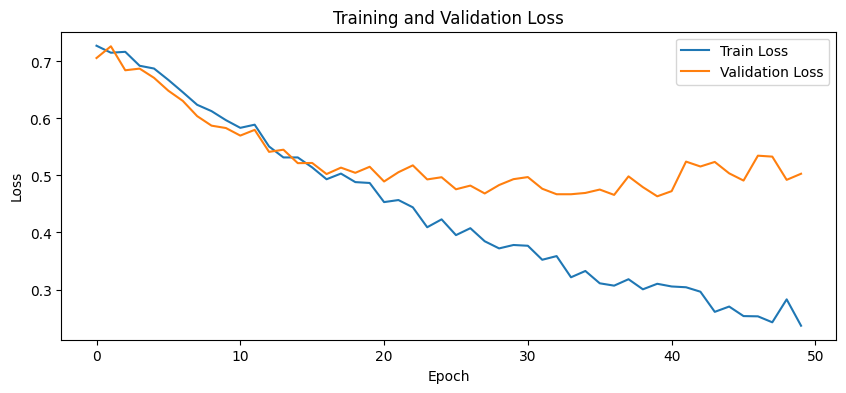

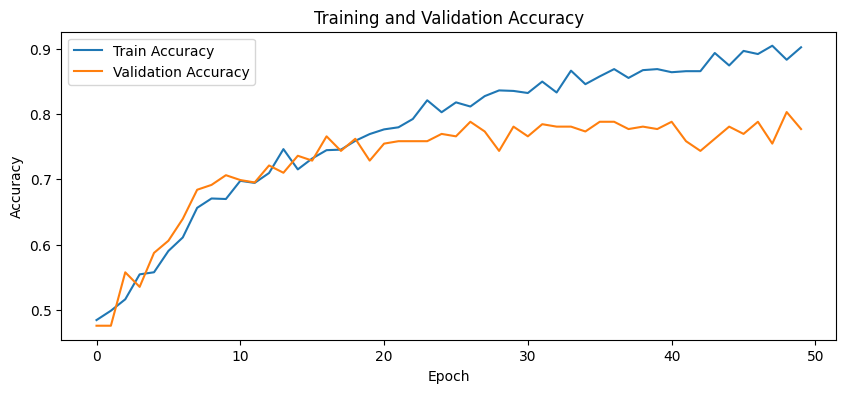

In [28]:
import matplotlib.pyplot as plt

# ======== Loss Curve ========
plt.figure(figsize=(10,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# ======== Accuracy Curve ========
plt.figure(figsize=(10,4))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
